In [1]:
import sys

sys.path.append("../")

In [2]:
import requests
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands
from datetime import datetime

import matplotlib.pyplot as plt


In [3]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
TIMEFRAME = '1h'

LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, interval='1m'):
    batches = []

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= datetime.utcnow():
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        return df



In [4]:
class Hurst():
    """
    If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
    Source: https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing
    """

    def __init__(self):
        self.h_min = 0.0
        self.h_max = 0.4
        self.look_back = 126
        self.lag_max = 100
        self.h_value = None

    def apply_hurst(self, time_series):
        """Returns the Hurst Exponent of the time series vector ts"""
        # Create the range of lag values
        lags = range(2, self.lag_max)

        # Calculate the array of the variances of the lagged differences
        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]

        # Use a linear fit to estimate the Hurst Exponent
        poly = np.polyfit(np.log10(lags), np.log10(tau), 1)

        # Return the Hurst exponent from the polyfit output
        self.h_value = poly[0] * 2.0

    def use(self):
        return (self.h_value < self.h_max) and (self.h_value > self.h_min)

In [5]:
symbols = ['XRP', 'ALGO']
half_life = 28
hedge_ratio = [35.58243748, -27.26667541]


In [6]:
data = []

for symbol in symbols:
    df = get_candles(base=symbol, quote='USDT', start_date=datetime.now() - timedelta(days=60), interval=TIMEFRAME)
    if df is None:
        continue

    df.rename(columns={'close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    log = np.log(df[symbol].astype(np.float32))
    data.append(log)

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,XRP,ALGO
0,-0.894040,-0.818030
1,-0.894285,-0.819618
2,-0.914792,-0.830572
3,-0.896488,-0.808783
4,-0.904362,-0.823028


In [7]:
nb_symbols = 2

def calculate_spread(df):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[symbols[i]] * hedge_ratio[i]
        else:
            spread += df[symbols[i]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread

In [8]:
spread = calculate_spread(df)

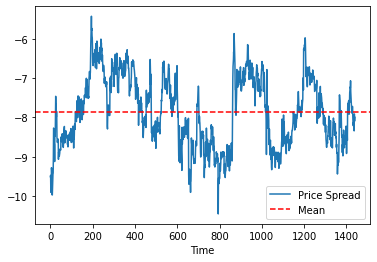

In [9]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [10]:
adf_test(spread, verbose=True)

Results of Dickey-Fuller Test:
Result: The series is  stationary


0.03584124294319248

In [11]:
hurst = Hurst()
hurst.apply_hurst(spread)
hurst.use()

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


False